In [256]:
import numpy as np
import os
import matplotlib.pyplot as plt
import gzip
import math
import pandas as pd
import random
import scipy.stats
from dtw import dtw
from numpy.linalg import norm
from scipy.stats import spearmanr
%matplotlib inline  

measures      = ['degree', 'clustering', 'pagerank', 'betweenness', 'closeness', 'constraint']  
top_directors = {   'nm0000184' : 'G Lucas',
                    'nm0000233' : 'Q Tarantino',
                    'nm0000229' : 'S Spielberg',
                    'nm0000040' : 'S Kubrick',
                    'nm0634240' : 'C Nolan',
                    'nm0000033' : 'A Hitchcock',
                    'nm0000122' : 'Charlie Chaplin',
                    'nm0000631' : 'Ridley Scott',
                    'nm0001053' : 'E Coen',
                    'nm0000142' : 'C Eastwood',
                    'nm0001392' : 'P Jackson',
                    'nm0000591' : 'R Polanski',
                    'nm0000154' : 'M Gibson',
                    'nm0001232' : 'M Forman',   
                    'nm0001628' : 'S Pollack'}


def round_up_to_odd(f):
    return np.ceil(f) // 2 * 2 + 1


def getBinnedDistribution(x, y, nbins):

    n, bins   = np.histogram(x, bins=nbins)
    sy, _  = np.histogram(x, bins=nbins, weights=y)
    mean = sy/n
     

    return _, mean



def getLogBinnedDistribution(x, y, nbins):

    bins   = 10 ** np.linspace(np.log10(min(x)), np.log10(max(x)), nbins)  
    values = [ np.mean([y[j]  for j in range(len(x)) if x[j] >= bins[i] and x[j] < bins[i+1]])  for i in range(nbins-1)]    
    error  = [ np.std( [y[j]  for j in range(len(x)) if x[j] >= bins[i] and x[j] < bins[i+1]])  for i in range(nbins-1)]
    bins   = (bins[1:] + bins[:-1])/2

    return bins, values, error



def getPercentileBinnedDistribution(x, y, nbins):

    x, y = zip(*sorted(zip(x, y), key=lambda tup: tup[0]))
    elements_per_bin = int(len(x)/float(nbins))

    xx  = [np.mean(x[i*elements_per_bin:(i+1)*elements_per_bin]) for i in range(nbins)]
    yy  = [np.mean(y[i*elements_per_bin:(i+1)*elements_per_bin]) for i in range(nbins)]
    std = [np.std(y[i*elements_per_bin:(i+1)*elements_per_bin])  for i in range(nbins)]

    return xx, yy, std


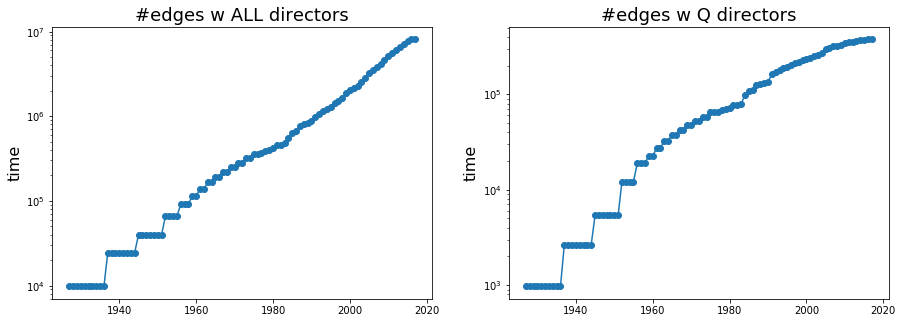

In [2]:
years_a, edges_a = zip(*[  line.strip().split('\t')  for line in open('NEWTemporal/networks_size_over_time.dat')  ])
years_Q, edges_Q = zip(*[  line.strip().split('\t')  for line in open('NEWTemporal/networks_size_over_time_QEVER.dat')  ])


years_a = [float(a) for a in years_a]
edges_a = [float(a) for a in edges_a]
years_Q = [float(a) for a in years_Q]
edges_Q = [float(a) for a in edges_Q]

f, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(years_a, edges_a, 'o-')
ax[1].plot(years_Q, edges_Q, 'o-')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_title('#edges w ALL directors', fontsize = 18)
ax[1].set_title('#edges w Q directors', fontsize = 18)
ax[0].set_ylabel('#edges', fontsize = 16)
ax[0].set_ylabel('time', fontsize = 16)
ax[1].set_ylabel('time', fontsize = 16)

    
plt.savefig('TEMPNW.png')

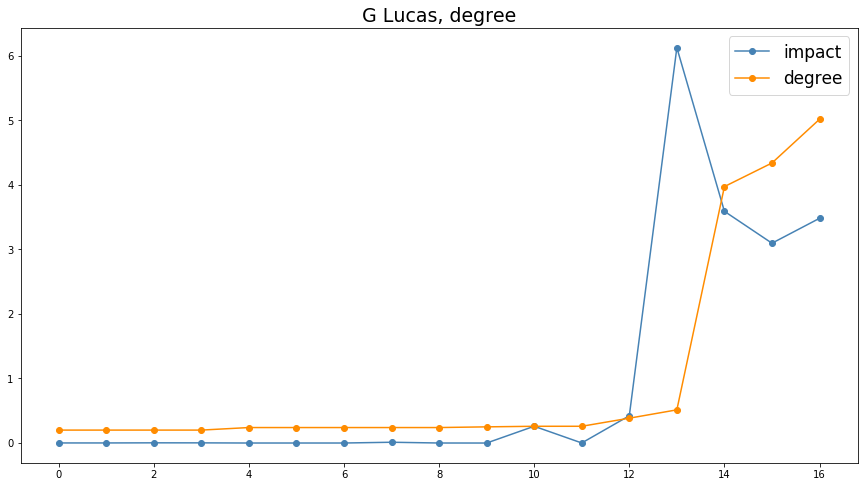

In [3]:
def get_centralities(dirid, measures, column = 1):

    centralities = {}

    for line in open('NEWTemporal/4_directors_centralities/' +dirid+'.dat'):
        
        fields = line.strip().split('\t')
        fields = [float(f) for f in fields]
        centralities[fields[0]] = fields[column]
        
    return centralities, measures[column-1]



def get_plot(ax, centralities, dirid, name, meas):
    
    x = []
    y = []
    z = []

    for line in gzip.open('simple-careers/film-director-simple-careers/' + dirid + '_director_simple_career.gz'):

        if 'year' not in line:
            fields = line.strip().split()
            year   = float(fields[1])
            impact = float(fields[3])

            if year in centralities:

                x.append(year)
                y.append(impact)
                z.append(centralities[year])
                
 
    y, z, x = zip(*sorted([ (y[ijk], z[ijk], x[ijk]) for ijk in range(len(x)) ], key=lambda tup: tup[2]))    


    zavg = np.mean(z)

    z = [zz/zavg for zz in z]
   # y = [math.log(yy) for yy in y]
    yavg = np.mean(y)

    y = [yy/yavg for yy in y]



    ax.set_title(name + ', ' + meas, fontsize = 19)
    ax.plot(y, 'o-', color = 'steelblue', label = 'impact')
    ax.plot(z, 'o-', color = 'darkorange', label = meas)
    ax.legend(loc = 'best', fontsize = 17)



dirid     = 'nm0000184'
    
centralities, meas = get_centralities(dirid, measures, column = 1)

f, ax = plt.subplots(1,1,figsize=(15,8))
get_plot(ax, centralities, dirid, top_directors[dirid], meas)


    

# Different measures for Lucas and Spielberg

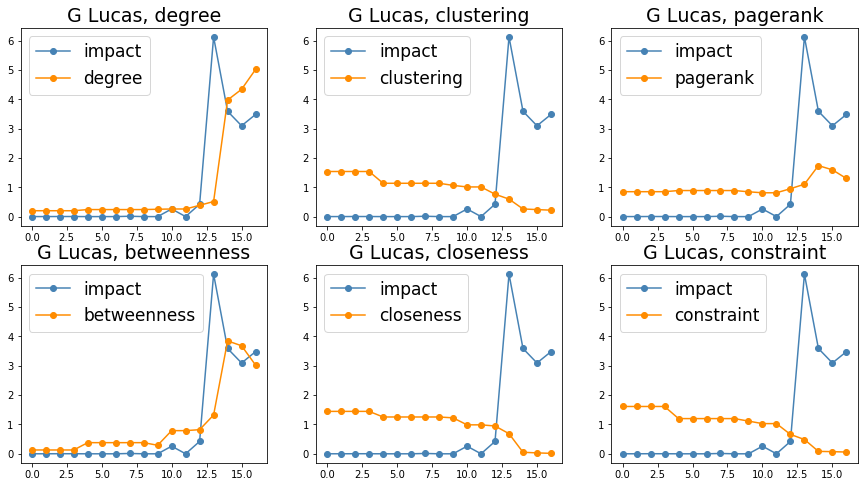

In [5]:
f, ax = plt.subplots(2,3,figsize=(15,8))
dirid = 'nm0000184'

centralities, meas = get_centralities(dirid, measures, column = 1)
get_plot(ax[0,0], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 2)
get_plot(ax[0,1], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 3)
get_plot(ax[0,2], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 4)
get_plot(ax[1,0], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 5)
get_plot(ax[1,1], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 6)
get_plot(ax[1,2], centralities, dirid, top_directors[dirid], meas)

plt.savefig('1_diffmeasures_lucas')

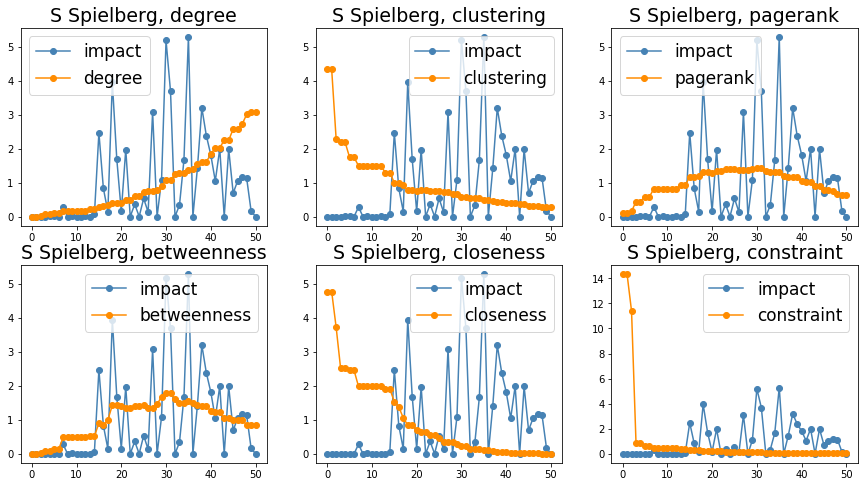

In [4]:
f, ax = plt.subplots(2,3,figsize=(15,8))
dirid = 'nm0000229'


centralities, meas = get_centralities(dirid, measures, column = 1)
get_plot(ax[0,0], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 2)
get_plot(ax[0,1], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 3)
get_plot(ax[0,2], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 4)
get_plot(ax[1,0], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 5)
get_plot(ax[1,1], centralities, dirid, top_directors[dirid], meas)

centralities, meas = get_centralities(dirid, measures, column = 6)
get_plot(ax[1,2], centralities, dirid, top_directors[dirid], meas)

plt.savefig('1_diffmeasures_spielberg')

# Degree for different big names

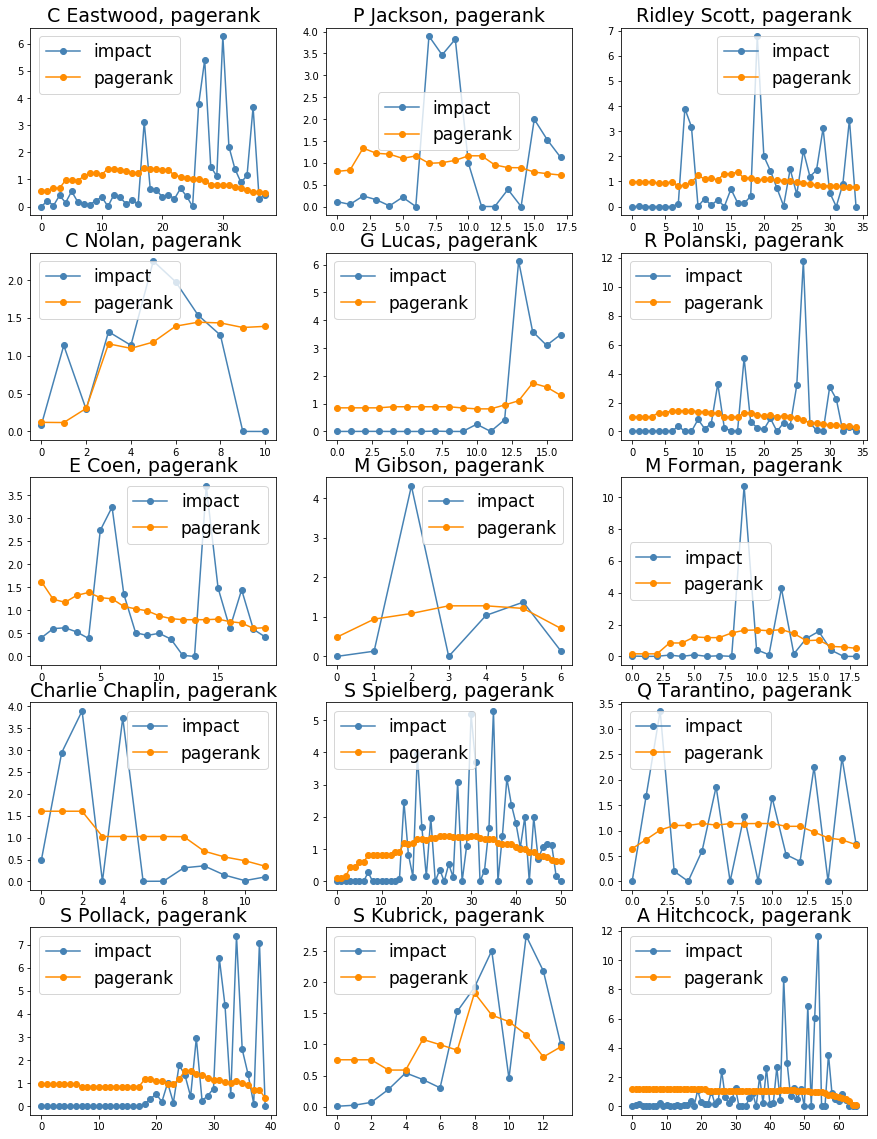

In [6]:
measid   = 3
f, ax    = plt.subplots(5, 3, figsize = (15,20))
indicies = [(i,j) for i in range(5) for j in range(3)]

for ind, (dirid, name) in enumerate(top_directors.items()):
    
    centralities, meas = get_centralities(dirid, measures, column = measid)
    get_plot(ax[indicies[ind]], centralities, dirid, top_directors[dirid], meas)
    
plt.savefig('2_diffdirectors_pagerank')

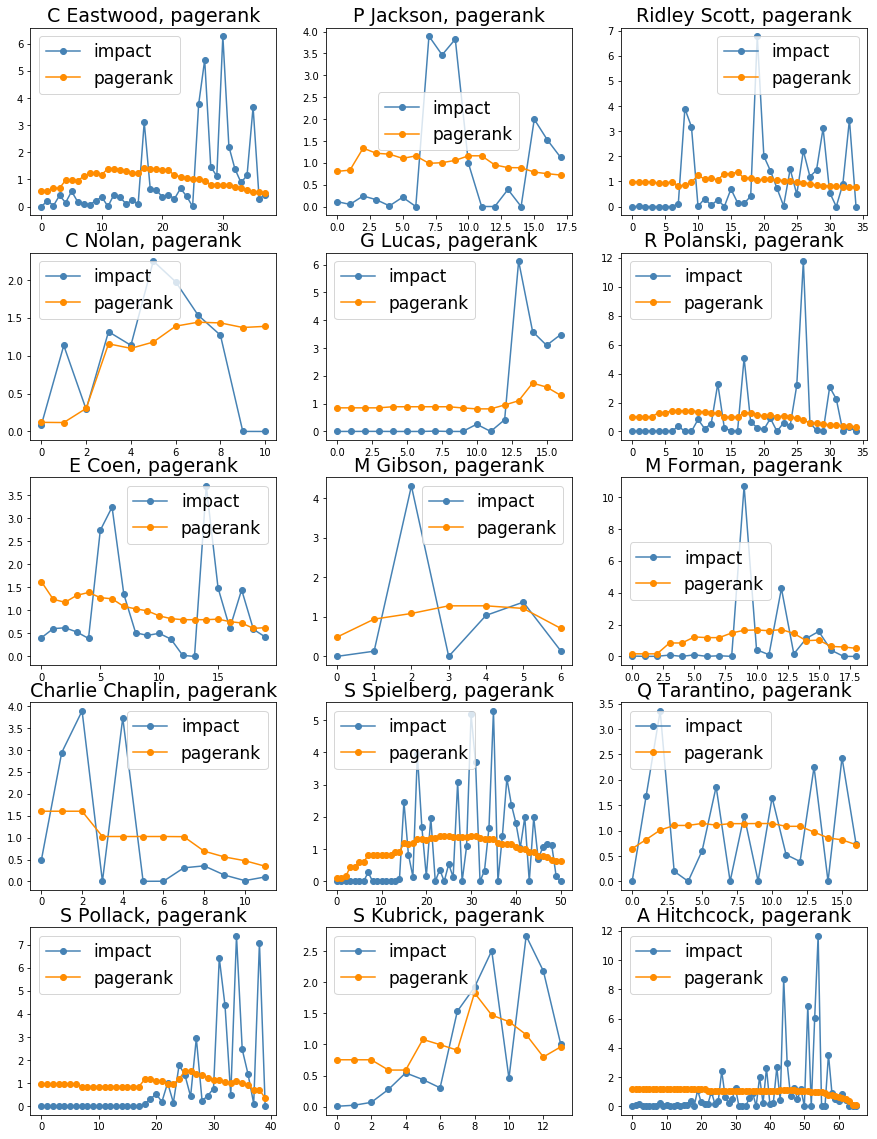

In [7]:
measid   = 3
f, ax    = plt.subplots(5, 3, figsize = (15,20))
indicies = [(i,j) for i in range(5) for j in range(3)]

for ind, (dirid, name) in enumerate(top_directors.items()):
    
    centralities, meas = get_centralities(dirid, measures, column = measid)
    get_plot(ax[indicies[ind]], centralities, dirid, top_directors[dirid], meas)
    
plt.savefig('2_diffdirectors_degree')

# Correlation shifting

C0:      0.5397639049260997
Random:  -0.22864998750341722
Correl:  1111.1
DTW:     0.6195046029362997
shift:   0


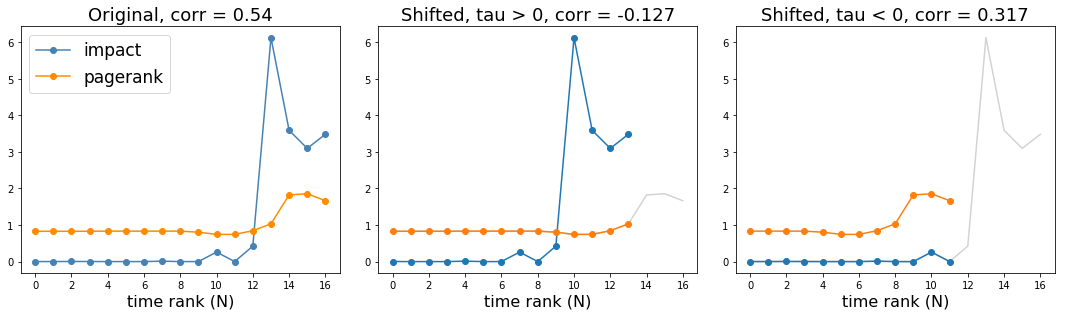

In [107]:
def get_plot_correl(ax, centralities, dirid, name, meas, logimpact = False):
    
    x = []
    y = []
    z = []

    for line in gzip.open('simple-careers/film-director-simple-careers/' + dirid + '_director_simple_career.gz'):

        if 'year' not in line:
            fields = line.strip().split()
            year   = float(fields[1])
            impact = float(fields[3])

            if year in centralities:

                x.append(year)
                
                if logimpact:
                    if impact == 0.0: impact = 1.0
                    y.append(math.log(impact))
                else:
                    y.append(impact)
                z.append(centralities[year])
                
 
    y, z, x = zip(*sorted([ (y[ijk], z[ijk], x[ijk]) for ijk in range(len(x)) ], key=lambda tup: tup[2]))    

    zavg = np.mean(z)
    z    = [zz/zavg for zz in z]
    yavg = np.mean(y)
    y    = [yy/yavg for yy in y]

    ax.set_title(name + ', ' + meas, fontsize = 19)
    ax.plot(y, 'o-', color = 'steelblue', label = 'impact')
    ax.plot(z, 'o-', color = 'darkorange', label = meas)
    ax.legend(loc = 'best', fontsize = 17)

    a = list(z)
    random.shuffle(a)
    
    return y, z, spearmanr(y, z)[0], spearmanr(y, a)[0]



def get_centralities(dirid, measures, column = 1):

    centralities = {}

    for line in open('NEWTemporal/4_directors_centralities_QEVER/' +dirid+'.dat'):
        
        fields = line.strip().split('\t')
        fields = [float(f) for f in fields]
        centralities[fields[0]] = fields[column]
        
    return centralities, measures[column-1]


def shift_time_series(x, y, tau):
    
    
    x2 = []
    y2 = []
    
    if tau >= 0:
        for i in range(tau, len(x)):
            x2.append(x[i])

        for i in range(len(y)-tau):
            y2.append(y[i])        
    
    else:
        for i in range(len(x)+tau):
            x2.append(x[i])        
        for i in range(-tau, len(y)):
            y2.append(y[i])  

    
    return x2, y2, spearmanr(x2, y2)[0]
    
    
    
measid   = 3
f, ax    = plt.subplots(1, 3, figsize = (15,4.5))
indicies = [(i,j) for i in range(5) for j in range(3)]

for ind, (dirid, name) in enumerate(top_directors.items()):
    
    if 'nm0000184' in dirid:
    
        centralities, meas = get_centralities(dirid, measures, column = measid)

        x,    y,    c0, c_rand  = get_plot_correl(ax[0], centralities, dirid, top_directors[dirid], meas, logimpact = False)
        x_s,  y_s , c1          = shift_time_series(x,y, 3)
        x_s2, y_s2, c2          = shift_time_series(x,y, -5)


        
        print 'C0:     ', c0
        print 'Random: ', c_rand
        print 'Correl: ', c_s 
        print 'DTW:    ', cdtw
        print 'shift:  ', shiftm
   

ax[1].plot(y, '-', color = 'lightgrey')
ax[1].plot(x_s, 'o-')
ax[1].plot(y_s, 'o-')

ax[2].plot(x, '-', color = 'lightgrey')
ax[2].plot(x_s2, 'o-')
ax[2].plot(y_s2, 'o-')


ax[0].set_title('Original, corr = ' +  str(round(c0, 3))  , fontsize = 18)
ax[1].set_title('Shifted, tau > 0, corr = ' +  str(round(c1, 3)) , fontsize = 18)
ax[2].set_title('Shifted, tau < 0, corr = ' +  str(round(c2, 3)) , fontsize = 18)

[ax[i].set_xlabel('time rank (N)', fontsize = 16) for i in range(3)]

plt.tight_layout()
#plt.suptitle('Spielberg, pagerank', fontsize = 18)

plt.savefig('lucas_shift.png')

C0:      -0.04914019746654562
Random:  -0.09705188999642758
Correl:  1111.1
DTW:     -0.04914019746654562
shift:   7
7


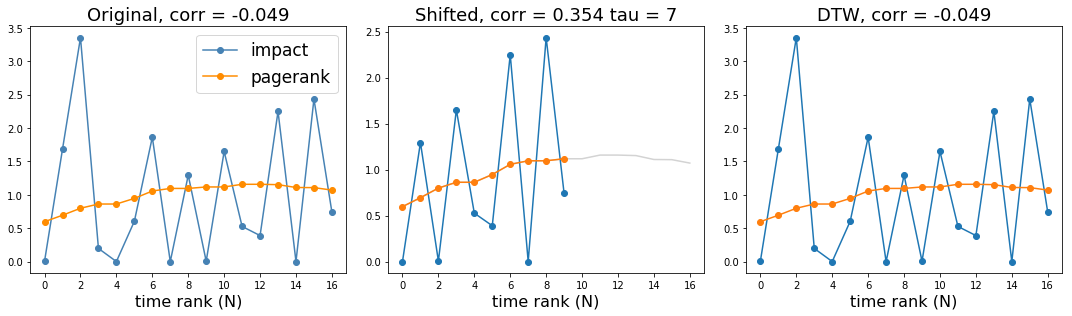

In [119]:
def dtw_timeserires(x, y):

    x_dtw = np.array(x).reshape(-1, 1)
    y_dtw = np.array(y).reshape(-1, 1)
    dist, cost, acc, path = dtw(x_dtw, y_dtw, dist=lambda x_dtw, y_dtw: norm(x_dtw - y_dtw, ord=1))
    map_x, map_y = path
   
    xnew = x_dtw[map_x]
    ynew = y_dtw[map_y]

    cdtw = spearmanr(xnew, ynew)
    return xnew, ynew, cdtw[0]


  

def get_tau_star(x,y):
    
    n       = len(x)/2
    maxc    = -10
    taustar = -1000000000
    

    
    for tau in range(-n, n):
        xx, yy, corr = shift_time_series(x, y, tau)  
        if corr > maxc:
            taustar = tau  
            maxc = corr
          
    xstar, ystar, corrstar = shift_time_series(x, y, taustar)      
            
    return taustar, xstar, ystar, corrstar
            
    
    


    
measid   = 3
f, ax    = plt.subplots(1, 3, figsize = (15,4.5))
indicies = [(i,j) for i in range(5) for j in range(3)]

for ind, (dirid, name) in enumerate(top_directors.items()):
    
    if 'nm0000233' in dirid:
    
        centralities, meas = get_centralities(dirid, measures, column = measid)

        x,   y,   c0, c_rand            = get_plot_correl(ax[0], centralities, dirid, top_directors[dirid], meas, logimpact = False)
        taustar, xstar, ystar, corrstar = get_tau_star(x,y)
        x_d, y_d, cdtw                  = dtw_timeserires(x,y)

        
        
        
        print 'C0:     ', c0
        print 'Random: ', c_rand
        print 'Correl: ', c_s 
        print 'DTW:    ', cdtw
        print 'shift:  ', taustar
   


if taustar > 0:
    ax[1].plot(y, '-', color = 'lightgrey')
else:
    ax[1].plot(x, '-', color = 'lightgrey')
ax[1].plot(xstar, 'o-')
ax[1].plot(ystar, 'o-')


ax[2].plot(x_d, 'o-')
ax[2].plot(y_d, 'o-')


print taustar

ax[0].set_title('Original, corr = ' +  str(round(c0, 3))  , fontsize = 18)
ax[1].set_title('Shifted, corr = ' +  str(round(corrstar, 3)) + ' tau = ' + str(taustar), fontsize = 18)
ax[2].set_title('DTW, corr = ' +  str(round(cdtw, 3)), fontsize = 18)

[ax[i].set_xlabel('time rank (N)', fontsize = 16) for i in range(3)]

plt.tight_layout()
#plt.suptitle('Spielberg, pagerank', fontsize = 18)

plt.savefig('tarantini.png')


# Read all career data

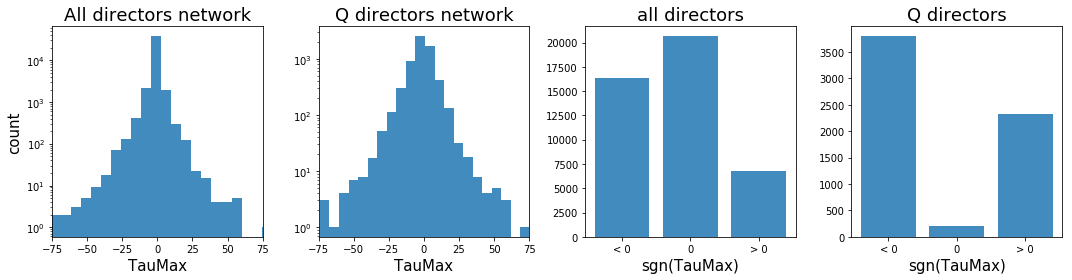

In [286]:
shifts_a = [float(line.strip()) for line in open('NEWTemporal/2_shiftwindow_sizes.dat')]
shifts_Q = [float(line.strip()) for line in open('NEWTemporal/2_shiftwindow_sizes_QEVER.dat') ]

f, ax = plt.subplots(1,4,figsize=(15,4))


ax[0].hist(shifts_a, bins = 50, alpha = 0.85)
ax[0].set_yscale('log')
ax[1].hist(shifts_Q, bins = 50, alpha = 0.85)
ax[1].set_yscale('log')

ax[0].set_title('All directors network', fontsize = 18)
ax[1].set_title('Q directors network', fontsize = 18)
ax[0].set_xlabel('TauMax', fontsize = 15)
ax[1].set_xlabel('TauMax', fontsize = 15)

ax[0].set_xlim([-75,75])
ax[1].set_xlim([-75,75])
ax[0].set_ylabel('count', fontsize = 15)



neg  = len([a for a in shifts_a if a < 0])
pos  = len([a for a in shifts_a if a > 0])
null = len([a for a in shifts_a if a == 0])

ax[2].set_title('all directors', fontsize = 18)
ax[2].bar(['< 0', '0', '> 0'], [neg, null, pos], alpha = 0.85)
ax[2].set_xlabel('sgn(TauMax)', fontsize = 15)




neg  = len([a for a in shifts_Q if a < 0])
pos  = len([a for a in shifts_Q if a > 0])
null = len([a for a in shifts_Q if a == 0])

ax[3].set_title('Q directors', fontsize = 18)
ax[3].bar(['< 0', '0', '> 0'], [neg, null, pos], alpha = 0.85)
ax[3].set_xlabel('sgn(TauMax)', fontsize = 15)




#NEWTemporal/1_career_centrality_correlations.dat
plt.tight_layout()
plt.savefig('shiftsize_hist.png')

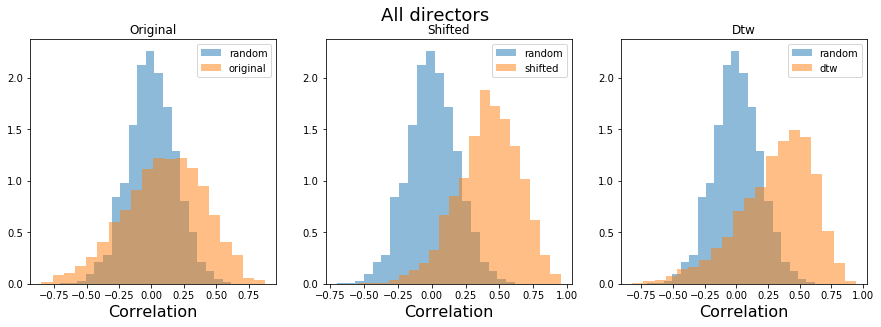

In [140]:
def get_correl_data(tipus = ''):

    cs_rand  = []
    cs_orig  = []
    cs_shift = []
    cs_dtw   = []

    lengths = []

    for ind, line in enumerate(open('NEWTemporal/1_career_centrality_correlations'+tipus+'.dat')):

        if 'director' not in line:
            #if ind == 499: break

            directorid, careerlength, c_random, c_original, c_shifted, c_dtw = line.strip().split('\t')
            careerlength, c_random, c_original, c_shifted, c_dtw = [float(a) for a in [careerlength, c_random, c_original, c_shifted, c_dtw ]]

            if careerlength > 19:
                if str(c_random) != 'nan':

                    cs_rand.append( c_random )
                    cs_orig.append( c_original )
                    cs_shift.append( c_shifted )
                    cs_dtw.append( c_dtw )                  
                    
                    lengths.append(careerlength)
                    
            
    return cs_rand, cs_orig, cs_shift, cs_dtw, lengths 
            

    
f, ax = plt.subplots(1,3,figsize=(15,4.5))

cs_rand, cs_orig, cs_shift, cs_dtw, lengths = get_correl_data('')

ax[0].hist(cs_rand, bins = 20, alpha = 0.5, label = 'random', density = True)
ax[0].hist(cs_orig, bins = 20, alpha = 0.5, label = 'original', density = True)

ax[1].hist(cs_rand,  bins = 20, alpha = 0.5, label = 'random', density = True)
ax[1].hist(cs_shift, bins = 20, alpha = 0.5, label = 'shifted', density = True)

ax[2].hist(cs_rand, bins = 20, alpha = 0.5, label = 'random', density = True)
ax[2].hist(cs_dtw,  bins = 20, alpha = 0.5, label = 'dtw', density = True)



ax[0].set_title('Original')
ax[1].set_title('Shifted')
ax[2].set_title('Dtw')


ax[0].legend(loc = 'best')
ax[1].legend(loc = 'best')
ax[2].legend(loc = 'best')
plt.suptitle('All directors', fontsize = 18)
   
[ax[i].set_xlabel('Correlation', fontsize = 16) for i in range(3)]
    
plt.savefig('correl_above10.png')
    

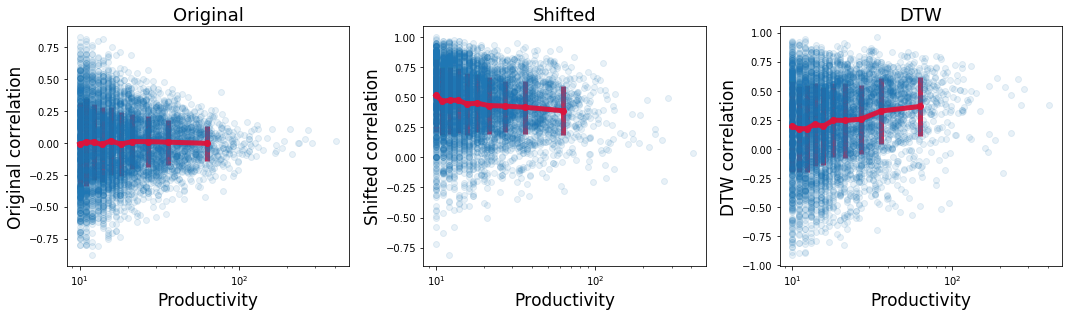

In [126]:
f, ax = plt.subplots(1,3,figsize=(15,4.5))

ax[0].plot(lengths, cs_rand, 'o', linewidth = 0, alpha = 0.1)
bx, by, berr = getPercentileBinnedDistribution(lengths, cs_rand,10 )
ax[0].errorbar(bx, by, yerr = berr, fmt = 'o-', color = 'crimson', linewidth = 5, alpha = 0.95)
ax[0].set_xscale('log')
ax[0].set_xlabel('Productivity', fontsize = 17)
ax[0].set_ylabel('Original correlation', fontsize = 17)
ax[0].set_title('Original', fontsize = 18)



ax[1].plot(lengths, cs_shift, 'o', linewidth = 0, alpha = 0.1)
bx, by, berr = getPercentileBinnedDistribution(list(lengths), list(cs_shift),10 )
ax[1].errorbar(bx, by, yerr = berr, fmt = 'o-', color = 'crimson', linewidth = 5, alpha = 0.95)
ax[1].set_xscale('log')
ax[1].set_xlabel('Productivity', fontsize = 17)
ax[1].set_ylabel('Shifted correlation', fontsize = 17)
ax[1].set_title('Shifted', fontsize = 18)


ax[2].plot(lengths, cs_dtw, 'o', linewidth = 0, alpha = 0.1)
bx, by, berr = getPercentileBinnedDistribution(lengths, cs_dtw,10 )
ax[2].errorbar(bx, by, yerr = berr, fmt = 'o-', color = 'crimson', linewidth = 5, alpha = 0.95)
ax[2].set_xscale('log')
ax[2].set_xlabel('Productivity', fontsize = 17)
ax[2].set_ylabel('DTW correlation', fontsize = 17)
ax[2].set_title('DTW', fontsize = 18)

plt.tight_layout()
plt.savefig('prod_corr.png')


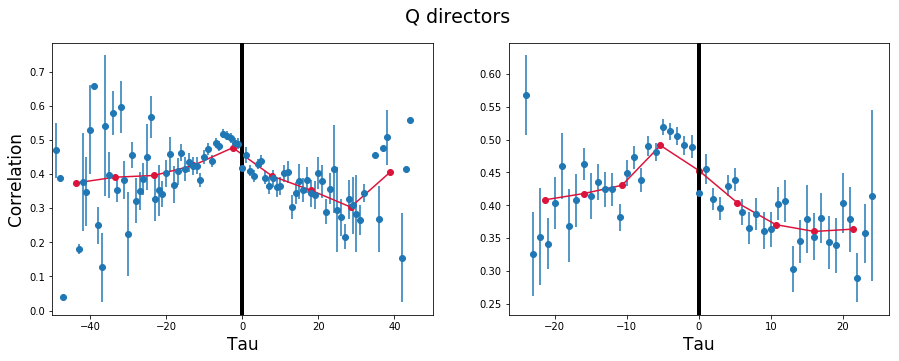

In [291]:
tau_corr   = {}
tau_corr_5 = {}

def correlrho(tipus = ''):

    for ind, line in enumerate(open('NEWTemporal/3_corr_shift'+tipus+'.dat')):
        #if ind == 100: break
        dirid, tau, corr, prod = line.strip().split('\t')
        tau = float(tau)
        corr = float(corr)
        

        if tau > -50 and tau < 50:

            if tau not in tau_corr:
                tau_corr[tau] = [corr]
            else:
                tau_corr[tau].append(corr)

        if tau > -25 and tau < 25:

            if tau not in tau_corr_5:
                tau_corr_5[tau] = [corr]
            else:
                tau_corr_5[tau].append(corr)     

    x = []
    y = []
    yerr  = []
    nbins =9

    for tau, correls in tau_corr.items():

        if np.mean(correls) < 1.1:
            x.append(tau)
            y.append(np.mean(correls))
            yerr.append(np.std(correls)/math.sqrt(len(correls)))


    f, ax = plt.subplots(1,2,figsize=(15,5))

    bx, by = getBinnedDistribution(x, y,nbins )
    bx = (bx[1:] + bx[:-1])/2 

    ax[0].errorbar(x, y, yerr = yerr,fmt = 'o')
    ax[0].plot(bx, by,  'o-', color = 'crimson')


    x = []
    y = []
    yerr = []

    for tau, correls in tau_corr_5.items():

        if np.mean(correls) < 1.1 and len(correls) > 1:
            x.append(tau)
            y.append(np.mean(correls))
            yerr.append(np.std(correls)/math.sqrt(len(correls)))


    bx, by = getBinnedDistribution(x, y,nbins )
    bx = (bx[1:] + bx[:-1])/2              
    ax[1].errorbar(x, y, yerr = yerr,fmt = 'o')
    ax[1].plot(bx, by,  'o-', color = 'crimson')

    ax[0].set_xlim([-50,50])
    #ax[1].set_xlim([-50,50])


    ax[1].set_xlabel('Tau', fontsize = 17)
    ax[0].set_xlabel('Tau', fontsize = 17)
    ax[0].set_ylabel('Correlation', fontsize = 17)
 

    ax[0].axvline(x=0.0, color = 'black', linewidth = 4)
    ax[1].axvline(x=0.0, color = 'black', linewidth = 4)
        
    
    if 'Q' in tipus: tipus = 'Q directors'
    else: tipus = 'Q directors'
    plt.suptitle(tipus, fontsize = 19)
    plt.savefig('correlrho_' + tipus + '.png')

correlrho('_QEVER')


### Correlation vs success

In [232]:
def add_df_meas(meas, tipus):

    df = pd.DataFrame(meas.items(), columns = ['name', tipus])
    df.index = df.name
    df = df.drop(columns = ['name'])    
    
    return df


success = pd.DataFrame()
df_altmeasures = pd.DataFrame.from_csv('ALT_success_measures.csv', sep ='\t')

directors, best  = zip(*[line.strip().split('\t') for line in open('directors_Imax.dat')])
success          = add_df_meas({directors[i] : float(best[i]) for i in range(len(best))}, 'maxI')
directorss, summ = zip(*[line.strip().split('\t') for line in open('directors_Isum.dat')])
directors_sum    = add_df_meas({directorss[i] : float(summ[i]) for i in range(len(summ))}, 'sumI')
directorsss, Q   = zip(*[line.strip().split('\t') for line in open('../QMODELNEW/pQData/Q_distribution_director-10_0.dat')])
directors_Q      = add_df_meas({directorsss[i] : float(Q[i]) for i in range(len(Q))}, 'Q')


correl = pd.DataFrame.from_csv('NEWTemporal/3_corr_shift_QEVER.dat', sep ='\t', header = None)
correl = correl.rename(columns = {0 : 'name', 1 : 'taumax', 2 : 'correl', 3 : 'prod'})
correl.index.name = 'name'


success = success.merge(directors_sum,  left_index=True,  right_index=True)
success = success.merge(directors_Q,    left_index=True,  right_index=True)
success = success.merge(df_altmeasures, left_index=True,  right_index=True)
success = success.merge(correl, left_index=True,  right_index=True)
success = success.drop(columns = ['sumI', 'max_crit', 'max_gross', 'max_opening', 'sum_opening'])
success.head()

/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  # This is added back by InteractiveShellApp.init_path()
/home/milan/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


,maxI,Q,meta_avg,sum_crit,sum_gross,taumax,correl,prod
name,,,,,,,,
nm0211643,145.0,14.600791,0.0,2.0,0.0,-2,-0.130931,8
nm0079906,939.0,46.687571,0.0,24.0,0.0,9,0.028933,20
nm0499939,417.0,43.795043,0.0,4.0,0.0,-4,0.640603,16
nm0107854,942.0,28.457348,0.0,71.0,0.0,-38,0.174566,78
nm0068691,1279.0,28.611050,0.0,55.0,0.0,-16,0.345575,80


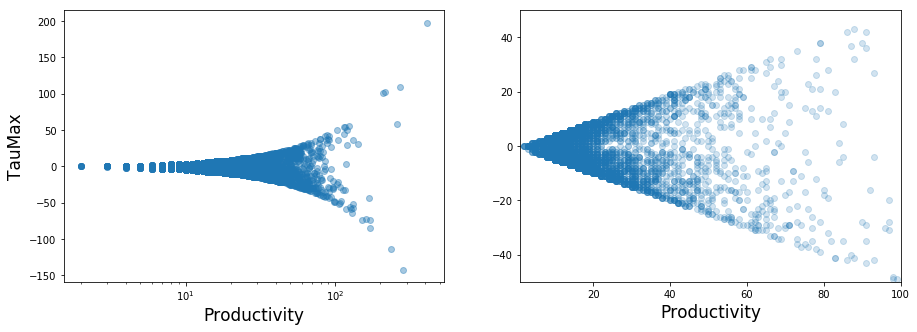

In [249]:
f, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(list(success['prod']), list(success.taumax), 'o', alpha = 0.4)
ax[0].set_xscale('log')

ax[1].plot(list(success['prod']), list(success.taumax), 'o', alpha = 0.2)
ax[1].set_ylim([-50,50])
ax[1].set_xlim([1,100])
#ax[1].set_xscale('log')

ax[0].set_xlabel('Productivity', fontsize = 17)
ax[1].set_xlabel('Productivity', fontsize = 17)
ax[0].set_ylabel('TauMax', fontsize = 17)




plt.savefig('prodtau.png')

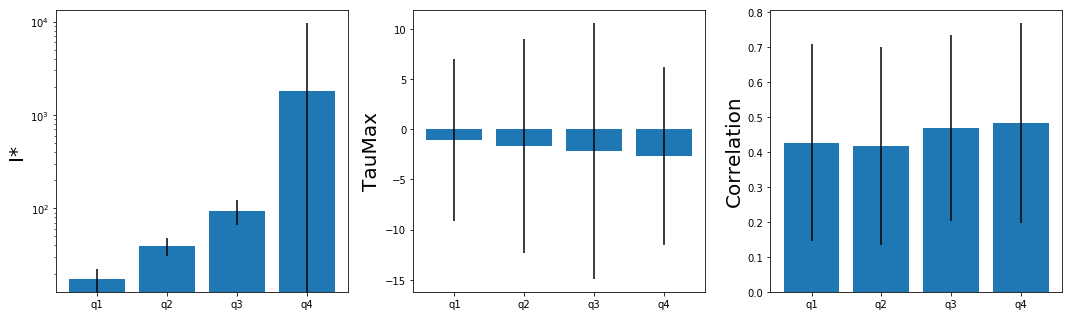

In [225]:
def get_quantiles(success, meas):

    success['quartile'] = pd.qcut(success[meas], 4, ['q1','q2','q3','q4'])
    Q1 = list(success[success['quartile'] == 'q1'].index)
    Q4 = list(success[success['quartile'] == 'q4'].index)
    
    data = {}
    
    data['success'] = []
    data['taumax']  = []
    data['correl']  = []
       
    for q in ['q1','q2','q3','q4']:
        
        avg_success = np.mean(success[success['quartile']==q][meas]) 
        std_success = np.std(success[success['quartile']==q][meas]) 
        
        
        avg_tau = np.mean(success[success['quartile']==q]['taumax']) 
        std_tau = np.std(success[success['quartile']==q]['taumax'])
        
        avg_corr = np.mean(success[success['quartile']==q]['correl']) 
        std_corr = np.std(success[success['quartile']==q]['correl']) 
        
        
        data['success'].append((q, avg_success, std_success))
        data['taumax'].append((q, avg_tau,     std_tau))
        data['correl'].append((q, avg_corr,    std_corr))

    return data
    
        
meas = 'Q'
data = get_quantiles(success, meas)

f, ax = plt.subplots(1,3,figsize=(15,4.5))



x    = [i[0] for i in data['success']]
y    = [i[1] for i in data['success']]
yerr = [i[2] for i in data['success']]
ax[0].bar(x, y, yerr = yerr)
ax[0].set_yscale('log')
ax[0].set_ylabel('I*', fontsize = 20)



x    = [i[0] for i in data['taumax']]
y    = [i[1] for i in data['taumax']]
yerr = [i[2] for i in data['taumax']]
ax[1].set_ylabel('TauMax', fontsize = 20)
ax[1].bar(x, y, yerr = yerr)


x    = [i[0] for i in data['correl']]
y    = [i[1] for i in data['correl']]
yerr = [i[2] for i in data['correl']]
ax[2].set_ylabel('Correlation', fontsize = 20)
ax[2].bar(x, y, yerr = yerr)

plt.tight_layout()
plt.savefig('quantiles.png')